#Download Data(執行一次即可；已執行)

In [ ]:
!pip install googleDriveFileDownloader #安裝套件語法 !pip install {套件名稱}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from googleDriveFileDownloader import googleDriveFileDownloader
gdownloader = googleDriveFileDownloader()
gdownloader.downloadFile("https://drive.google.com/uc?id=1kwYYWL67O0Dcbx3dvZIfbGg9NiHdyisr&export=download") # 連結到home work 1 data並下載

Download is starting
FILENAME ::: images.zip


0

In [ ]:
!unzip /content/images.zip -d /content/drive/MyDrive/Assignment1/Data #解壓縮

#Data Generator

In [63]:
import numpy as np
import tensorflow as tf
import os
import copy
import cv2
class DataGenerator(tf.keras.utils.Sequence):
  """Generates data for Keras"""
  def __init__(self, list_IDs, labels, path, batch_size=32, dim=(64,64,3), n_channels=1, n_classes=10, shuffle=True):
    """Initialization"""
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.path = path
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    """Denotes the number of batches per epoch"""
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    """Generate one batch of data"""
    #Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    #Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    #Generate data
    X,y = self.__data_generation(list_IDs_temp)
    return X, y
  
  def on_epoch_end(self):
    """Updates indexes after each epoch"""
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    """Generates data containing batch_size samples""" #X : (n_smaples, *dim, n_channels)
    #Initialization
    X = np.empty((self.batch_size, *self.dim))
    y = np.empty((self.batch_size), dtype=int)

    #Generate data
    for i, ID in enumerate(list_IDs_temp):
      img = cv2.imread(self.path + ID)
      img_resize = cv2.resize(img,(64,64))
      X[i,] = img_resize
      y[i] = self.labels[ID]
  
    return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

#Modules

In [4]:
from google.colab import drive
drive.mount('/content/drive') #連接到自己的雲端

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2

#Load Raw Data

In [65]:
file_train = open("/content/drive/MyDrive/Assignment1/Data/train.txt")
file_test = open("/content/drive/MyDrive/Assignment1/Data/test.txt")
file_val = open("/content/drive/MyDrive/Assignment1/Data/val.txt")

In [66]:
train_path = list()
train_label = list()
for line in file_train:
  (path, label) = line.split()
  train_path.append(path)
  train_label.append(label)

In [67]:
test_path = list()
test_label = list()
for line in file_test:
  (path, label) = line.split()
  test_path.append(path)
  test_label.append(label)

In [68]:
val_path = list()
val_label = list()
for line in file_val:
  (path, label) = line.split()
  val_path.append(path)
  val_label.append(label)

In [69]:
file_train.close()
file_test.close()
file_val.close()

In [70]:
train_label = np.array(train_label)
len(np.unique(train_label))

50

因為全部的訓練集跑不完，所以把訓練集各label取200個

In [71]:
train_path_new = list()
train_label_new = list()
train_label_count = dict()
for i in range(len(train_path)):
  if f"{train_label[i]}" not in train_label_count:
    train_label_count[f"{train_label[i]}"] = 1
  elif train_label_count[f"{train_label[i]}"] == 200:
    continue
  else:
    train_label_count[f"{train_label[i]}"] = train_label_count[f"{train_label[i]}"] + 1
    train_path_new.append(train_path[i])
    train_label_new.append(train_label[i])
  
train_label_count

{'0': 200,
 '1': 200,
 '2': 200,
 '3': 200,
 '4': 200,
 '5': 200,
 '6': 200,
 '7': 200,
 '8': 200,
 '9': 200,
 '10': 200,
 '11': 200,
 '12': 200,
 '13': 200,
 '14': 200,
 '15': 200,
 '16': 200,
 '17': 200,
 '18': 200,
 '19': 200,
 '20': 200,
 '21': 200,
 '22': 200,
 '23': 200,
 '24': 200,
 '25': 200,
 '26': 200,
 '27': 200,
 '28': 200,
 '29': 200,
 '30': 200,
 '31': 200,
 '32': 200,
 '33': 200,
 '34': 200,
 '35': 200,
 '36': 200,
 '37': 200,
 '38': 200,
 '39': 200,
 '40': 200,
 '41': 200,
 '42': 200,
 '43': 200,
 '44': 200,
 '45': 200,
 '46': 200,
 '47': 200,
 '48': 200,
 '49': 200}

In [72]:
partition = {"train":train_path_new, "test":test_path, "val":val_path}

lab = dict()
for n in range(len(train_path_new)):
  lab[train_path_new[n]] = train_label_new[n]
for n in range(len(test_path)):
  lab[test_path[n]] = test_label[n]
for n in range(len(val_path)):
  lab[val_path[n]] = val_label[n]

In [73]:
batch_size=32
n_classes=50


train_gen = DataGenerator(partition["train"], lab, "/content/drive/MyDrive/Assignment1/Data/", batch_size = batch_size, n_classes = n_classes)
test_gen = DataGenerator(partition["test"], lab, "/content/drive/MyDrive/Assignment1/Data/", batch_size = batch_size, n_classes = n_classes)
val_gen = DataGenerator(partition["val"], lab, "/content/drive/MyDrive/Assignment1/Data/", batch_size = batch_size, n_classes = n_classes)

#CNN Model (Feature extract)

In [74]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2

In [75]:
model = Sequential([
  layers.Rescaling(1./255, input_shape = (64,64,3)),
  layers.Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=L2(1e-3)),
  layers.MaxPooling2D(),
  # layers.Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=L2(1e-3)),
  # layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(50, activation='relu', kernel_regularizer=L2(1e-3)),
])

In [76]:
model.compile(optimizer='adam', 
        loss="categorical_crossentropy",
        metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 4)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 50)                204850    
                                                                 
Total params: 204,962
Trainable params: 204,962
Non-trainable params: 0
________________________________________________

In [78]:
learning_rate = 1e-2
epochs = 5

In [79]:
history = model.fit(
  train_gen,
  validation_data = val_gen,
  shuffle = True,
  epochs = epochs
)

Epoch 1/5
310/310 [==============================] - 54s 170ms/step - loss: 13.4811 - accuracy: 0.0273 - val_loss: 13.3795 - val_accuracy: 0.0357
Epoch 2/5
310/310 [==============================] - 48s 156ms/step - loss: 13.1295 - accuracy: 0.0341 - val_loss: 12.8276 - val_accuracy: 0.0290
Epoch 3/5
310/310 [==============================] - 47s 151ms/step - loss: 12.8435 - accuracy: 0.0396 - val_loss: 12.8143 - val_accuracy: 0.0469
Epoch 4/5
310/310 [==============================] - 46s 147ms/step - loss: 12.8624 - accuracy: 0.0220 - val_loss: 12.8348 - val_accuracy: 0.0201
Epoch 5/5
310/310 [==============================] - 45s 146ms/step - loss: 12.8470 - accuracy: 0.0300 - val_loss: 12.8165 - val_accuracy: 0.0357


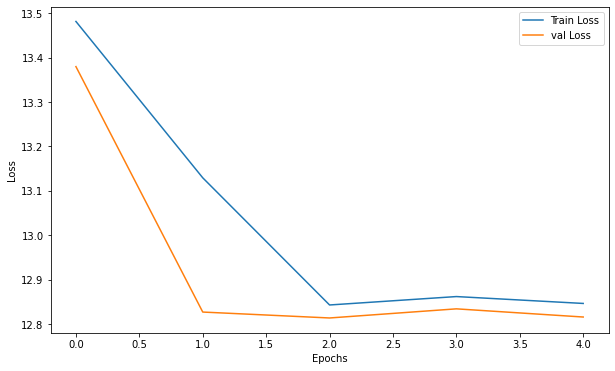

In [80]:
trn_loss = history.history["loss"]
val_loss = history.history["val_loss"]
trn_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.figure(figsize=(10,6))
plt.plot(trn_loss, label="Train Loss")
plt.plot(val_loss, label="val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

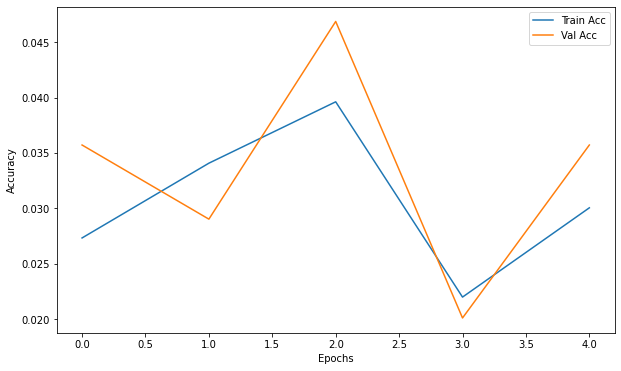

In [81]:
plt.figure(figsize=(10,6))
plt.plot(trn_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#Save Feature extract data

In [83]:
for i in tqdm(range(len(train_path_new))):
  img = cv2.imread(f"/content/drive/MyDrive/Assignment1/Data/{train_path_new[i]}")
  img = cv2.resize(img, (64,64))
  img_reshape = img.reshape(1,64,64,3)
  predict = model(img_reshape).numpy()
  a = train_label_new[i]
  np.save(f"/content/drive/MyDrive/Assignment1/Data/npy/train/{a}.{i+1:03}", predict)


100%|██████████| 9950/9950 [02:32<00:00, 65.10it/s]


In [84]:
img = cv2.imread(f"/content/drive/MyDrive/Assignment1/Data/{train_path_new[0]}")
img = cv2.resize(img, (64,64))
img_reshape = img.reshape(1,64,64,3)
predict = model(img_reshape).numpy()
predict

array([[0.       , 2.8522432, 3.156401 , 0.       , 7.7670493, 2.3733594,
        0.       , 0.       , 0.       , 0.       , 0.       , 4.5177894,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 5.668534 , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 4.3931894,
        0.       , 0.       , 3.3983889, 0.       , 0.       , 0.       ,
        2.9400337, 2.8649027, 0.       , 4.095402 , 0.       , 0.       ,
        0.       , 5.15292  ]], dtype=float32)

In [85]:
for i in tqdm(range(len(test_path))):
  img = cv2.imread(f"/content/drive/MyDrive/Assignment1/Data/{test_path[i]}")
  img = cv2.resize(img, (64,64))
  img_reshape = img.reshape(1,64,64,3)
  predict = model(img_reshape).numpy()
  a = test_label[i]
  np.save(f"/content/drive/MyDrive/Assignment1/Data/npy/test/{a}.{i+1:03}", predict)


100%|██████████| 450/450 [00:06<00:00, 72.95it/s]


In [86]:
for i in tqdm(range(len(val_path))):
  img = cv2.imread(f"/content/drive/MyDrive/Assignment1/Data/{val_path[i]}")
  img = cv2.resize(img, (64,64))
  img_reshape = img.reshape(1,64,64,3)
  predict = model(img_reshape).numpy()
  a = val_label[i]
  np.save(f"/content/drive/MyDrive/Assignment1/Data/npy/val/{a}.{i+1:03}", predict)


100%|██████████| 450/450 [00:05<00:00, 80.03it/s]


#Load data

In [6]:
trnset_path = os.listdir("/content/drive/MyDrive/Assignment1/Data/npy/train")
trn_x = list()
trn_y = list()
for filename in tqdm(trnset_path):
  img = np.load(f"/content/drive/MyDrive/Assignment1/Data/npy/train/{filename}")
  trn_x.append(img[0])
  lab = filename.split(".")[0]
  trn_y.append(lab)


100%|██████████| 9950/9950 [05:31<00:00, 30.03it/s] 


In [7]:
trn_x = pd.DataFrame(trn_x)
trn_y = pd.DataFrame(trn_y)

In [8]:
tstset_path = os.listdir("/content/drive/MyDrive/Assignment1/Data/npy/test")
tst_x = list()
tst_y = list()
for filename in tqdm(tstset_path):
  img = np.load(f"/content/drive/MyDrive/Assignment1/Data/npy/test/{filename}")
  tst_x.append(img[0])
  lab = filename.split(".")[0]
  tst_y.append(lab)


100%|██████████| 450/450 [00:07<00:00, 61.87it/s] 


In [9]:
tst_x = pd.DataFrame(tst_x)
tst_y = pd.DataFrame(tst_y)

In [10]:
valset_path = os.listdir("/content/drive/MyDrive/Assignment1/Data/npy/val")
val_x = list()
val_y = list()
for filename in tqdm(valset_path):
  img = np.load(f"/content/drive/MyDrive/Assignment1/Data/npy//val/{filename}")
  val_x.append(img[0])
  lab = filename.split(".")[0]
  val_y.append(lab)

val_x = np.array(val_x) 
val_y = np.array(val_y)

100%|██████████| 450/450 [00:06<00:00, 66.22it/s] 


In [11]:
val_x = pd.DataFrame(val_x)
val_y = pd.DataFrame(val_y)

#Classifier

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
def score(true_y, pred_y):
  y_count = dict()
  y_accuracy = dict()
  for ii in range(len(true_y.value_counts())):
    y_count[f"{ii}"] = {"right":0, "wrong":0}
  for i in range(len(true_y)):
    if true_y[0][i] == pred_y[i]:
      y_count[f"{true_y[0][i]}"]["right"] = y_count[f"{true_y[0][i]}"]["right"] + 1
    else:
      y_count[f"{true_y[0][i]}"]["wrong"] = y_count[f"{true_y[0][i]}"]["wrong"] + 1
  for i in y_count.keys():
    y_accuracy[f"{i}"] = y_count[f"{i}"]["right"] / (y_count[f"{i}"]["right"] + y_count[f"{i}"]["wrong"])
  
  return y_count, y_accuracy

##Decision Tree

In [278]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT.fit(trn_x, trn_y)

DecisionTreeClassifier()

In [279]:
test_predict_DT = DT.predict(tst_x)
acc = accuracy_score(test_predict_DT, tst_y)
acc

0.051111111111111114

In [280]:
test_DT_y_count, test_DT_y_accuracy = score(tst_y, test_predict_DT)
test_DT_y_accuracy

{'0': 0.0,
 '1': 0.0,
 '2': 0.0,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 0.1111111111111111,
 '10': 0.2222222222222222,
 '11': 0.2222222222222222,
 '12': 0.0,
 '13': 0.0,
 '14': 0.0,
 '15': 0.0,
 '16': 0.0,
 '17': 0.1111111111111111,
 '18': 0.0,
 '19': 0.0,
 '20': 0.0,
 '21': 0.0,
 '22': 0.0,
 '23': 0.0,
 '24': 0.1111111111111111,
 '25': 0.0,
 '26': 0.0,
 '27': 0.1111111111111111,
 '28': 0.0,
 '29': 0.0,
 '30': 0.0,
 '31': 0.0,
 '32': 0.1111111111111111,
 '33': 0.0,
 '34': 0.0,
 '35': 0.1111111111111111,
 '36': 0.0,
 '37': 0.1111111111111111,
 '38': 0.1111111111111111,
 '39': 0.0,
 '40': 0.1111111111111111,
 '41': 0.1111111111111111,
 '42': 0.0,
 '43': 0.0,
 '44': 0.1111111111111111,
 '45': 0.0,
 '46': 0.4444444444444444,
 '47': 0.1111111111111111,
 '48': 0.2222222222222222,
 '49': 0.1111111111111111}

In [281]:
val_predict_DT = DT.predict(val_x)
acc = accuracy_score(val_predict_DT, val_y)
acc

0.03777777777777778

In [282]:
val_DT_y_count, val_DT_y_accuracy = score(val_y, val_predict_DT)
val_DT_y_accuracy

{'0': 0.1111111111111111,
 '1': 0.0,
 '2': 0.0,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 0.0,
 '10': 0.2222222222222222,
 '11': 0.0,
 '12': 0.0,
 '13': 0.0,
 '14': 0.0,
 '15': 0.0,
 '16': 0.0,
 '17': 0.0,
 '18': 0.0,
 '19': 0.0,
 '20': 0.1111111111111111,
 '21': 0.2222222222222222,
 '22': 0.0,
 '23': 0.0,
 '24': 0.0,
 '25': 0.0,
 '26': 0.1111111111111111,
 '27': 0.0,
 '28': 0.0,
 '29': 0.0,
 '30': 0.0,
 '31': 0.0,
 '32': 0.1111111111111111,
 '33': 0.0,
 '34': 0.1111111111111111,
 '35': 0.1111111111111111,
 '36': 0.0,
 '37': 0.0,
 '38': 0.1111111111111111,
 '39': 0.1111111111111111,
 '40': 0.0,
 '41': 0.0,
 '42': 0.1111111111111111,
 '43': 0.0,
 '44': 0.1111111111111111,
 '45': 0.1111111111111111,
 '46': 0.1111111111111111,
 '47': 0.0,
 '48': 0.0,
 '49': 0.1111111111111111}

##Random Forest

In [283]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(trn_x, trn_y)

<ipython-input-283-8ea47ab5defa>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(trn_x, trn_y)


RandomForestClassifier()

In [284]:
test_predict_RF = forest.predict(tst_x)
acc = accuracy_score(tst_y, test_predict_RF)
acc

0.07111111111111111

In [285]:
test_RF_y_count, test_RF_y_accuracy = score(tst_y, test_predict_RF)
test_RF_y_accuracy

{'0': 0.3333333333333333,
 '1': 0.0,
 '2': 0.3333333333333333,
 '3': 0.1111111111111111,
 '4': 0.1111111111111111,
 '5': 0.0,
 '6': 0.0,
 '7': 0.1111111111111111,
 '8': 0.0,
 '9': 0.0,
 '10': 0.0,
 '11': 0.0,
 '12': 0.1111111111111111,
 '13': 0.0,
 '14': 0.2222222222222222,
 '15': 0.0,
 '16': 0.1111111111111111,
 '17': 0.1111111111111111,
 '18': 0.0,
 '19': 0.0,
 '20': 0.1111111111111111,
 '21': 0.1111111111111111,
 '22': 0.1111111111111111,
 '23': 0.0,
 '24': 0.1111111111111111,
 '25': 0.0,
 '26': 0.0,
 '27': 0.1111111111111111,
 '28': 0.0,
 '29': 0.0,
 '30': 0.0,
 '31': 0.0,
 '32': 0.0,
 '33': 0.0,
 '34': 0.0,
 '35': 0.0,
 '36': 0.0,
 '37': 0.1111111111111111,
 '38': 0.0,
 '39': 0.1111111111111111,
 '40': 0.1111111111111111,
 '41': 0.2222222222222222,
 '42': 0.0,
 '43': 0.0,
 '44': 0.3333333333333333,
 '45': 0.1111111111111111,
 '46': 0.1111111111111111,
 '47': 0.0,
 '48': 0.2222222222222222,
 '49': 0.1111111111111111}

In [286]:
val_predict_RF = forest.predict(val_x)
acc = accuracy_score(val_y, val_predict_RF)
acc

0.06444444444444444

In [287]:
val_RF_y_count, val_RF_y_accuracy = score(val_y, val_predict_RF)
val_RF_y_accuracy

{'0': 0.3333333333333333,
 '1': 0.0,
 '2': 0.0,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 0.0,
 '10': 0.0,
 '11': 0.0,
 '12': 0.0,
 '13': 0.0,
 '14': 0.0,
 '15': 0.0,
 '16': 0.0,
 '17': 0.0,
 '18': 0.1111111111111111,
 '19': 0.2222222222222222,
 '20': 0.0,
 '21': 0.1111111111111111,
 '22': 0.0,
 '23': 0.1111111111111111,
 '24': 0.0,
 '25': 0.0,
 '26': 0.1111111111111111,
 '27': 0.1111111111111111,
 '28': 0.0,
 '29': 0.1111111111111111,
 '30': 0.1111111111111111,
 '31': 0.0,
 '32': 0.0,
 '33': 0.1111111111111111,
 '34': 0.2222222222222222,
 '35': 0.0,
 '36': 0.0,
 '37': 0.1111111111111111,
 '38': 0.1111111111111111,
 '39': 0.3333333333333333,
 '40': 0.1111111111111111,
 '41': 0.1111111111111111,
 '42': 0.0,
 '43': 0.0,
 '44': 0.0,
 '45': 0.0,
 '46': 0.3333333333333333,
 '47': 0.0,
 '48': 0.4444444444444444,
 '49': 0.0}

##KNN

In [288]:
from sklearn import neighbors
n_neighbors = 15
NN = neighbors.KNeighborsClassifier(n_neighbors)
NN.fit(trn_x, trn_y)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=15)

In [289]:
test_NN_predict = NN.predict(tst_x)
test_NN_y_count, test_NN_y_accuracy = score(tst_y, test_NN_predict)
test_NN_y_accuracy

{'0': 0.3333333333333333,
 '1': 0.0,
 '2': 0.1111111111111111,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.1111111111111111,
 '8': 0.1111111111111111,
 '9': 0.0,
 '10': 0.0,
 '11': 0.0,
 '12': 0.2222222222222222,
 '13': 0.0,
 '14': 0.0,
 '15': 0.0,
 '16': 0.0,
 '17': 0.0,
 '18': 0.1111111111111111,
 '19': 0.0,
 '20': 0.3333333333333333,
 '21': 0.1111111111111111,
 '22': 0.2222222222222222,
 '23': 0.0,
 '24': 0.0,
 '25': 0.2222222222222222,
 '26': 0.0,
 '27': 0.1111111111111111,
 '28': 0.0,
 '29': 0.0,
 '30': 0.0,
 '31': 0.0,
 '32': 0.0,
 '33': 0.1111111111111111,
 '34': 0.1111111111111111,
 '35': 0.0,
 '36': 0.0,
 '37': 0.1111111111111111,
 '38': 0.1111111111111111,
 '39': 0.2222222222222222,
 '40': 0.0,
 '41': 0.2222222222222222,
 '42': 0.0,
 '43': 0.0,
 '44': 0.4444444444444444,
 '45': 0.2222222222222222,
 '46': 0.1111111111111111,
 '47': 0.0,
 '48': 0.1111111111111111,
 '49': 0.0}

In [290]:
val_NN_predict = NN.predict(val_x)
val_NN_y_count, val_NN_y_accuracy = score(val_y, val_NN_predict)
val_NN_y_accuracy

{'0': 0.2222222222222222,
 '1': 0.2222222222222222,
 '2': 0.0,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 0.0,
 '10': 0.1111111111111111,
 '11': 0.0,
 '12': 0.2222222222222222,
 '13': 0.1111111111111111,
 '14': 0.0,
 '15': 0.0,
 '16': 0.1111111111111111,
 '17': 0.0,
 '18': 0.0,
 '19': 0.0,
 '20': 0.2222222222222222,
 '21': 0.1111111111111111,
 '22': 0.0,
 '23': 0.1111111111111111,
 '24': 0.0,
 '25': 0.0,
 '26': 0.0,
 '27': 0.0,
 '28': 0.0,
 '29': 0.1111111111111111,
 '30': 0.1111111111111111,
 '31': 0.0,
 '32': 0.0,
 '33': 0.0,
 '34': 0.0,
 '35': 0.0,
 '36': 0.0,
 '37': 0.0,
 '38': 0.1111111111111111,
 '39': 0.3333333333333333,
 '40': 0.0,
 '41': 0.0,
 '42': 0.0,
 '43': 0.0,
 '44': 0.3333333333333333,
 '45': 0.0,
 '46': 0.1111111111111111,
 '47': 0.0,
 '48': 0.3333333333333333,
 '49': 0.0}

##CatBoost

In [14]:
!pip install catboost
import catboost as ctb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.2 MB/s eta 0:00:00


In [ ]:
model_CBC = ctb.CatBoostClassifier()
model_CBC.fit(trn_x, trn_y)

In [16]:
test_predict_Cat = model_CBC.predict(tst_x)
test_Cat_y_count, test_Cat_y_accuracy = score(tst_y, test_predict_Cat)
test_Cat_y_accuracy

{'0': 0.1111111111111111,
 '1': 0.1111111111111111,
 '2': 0.1111111111111111,
 '3': 0.1111111111111111,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.1111111111111111,
 '9': 0.0,
 '10': 0.1111111111111111,
 '11': 0.0,
 '12': 0.0,
 '13': 0.1111111111111111,
 '14': 0.2222222222222222,
 '15': 0.0,
 '16': 0.1111111111111111,
 '17': 0.2222222222222222,
 '18': 0.0,
 '19': 0.0,
 '20': 0.2222222222222222,
 '21': 0.0,
 '22': 0.2222222222222222,
 '23': 0.0,
 '24': 0.0,
 '25': 0.0,
 '26': 0.0,
 '27': 0.3333333333333333,
 '28': 0.0,
 '29': 0.2222222222222222,
 '30': 0.0,
 '31': 0.0,
 '32': 0.1111111111111111,
 '33': 0.1111111111111111,
 '34': 0.0,
 '35': 0.0,
 '36': 0.0,
 '37': 0.1111111111111111,
 '38': 0.0,
 '39': 0.2222222222222222,
 '40': 0.2222222222222222,
 '41': 0.3333333333333333,
 '42': 0.0,
 '43': 0.1111111111111111,
 '44': 0.3333333333333333,
 '45': 0.0,
 '46': 0.2222222222222222,
 '47': 0.0,
 '48': 0.4444444444444444,
 '49': 0.1111111111111111}

In [17]:
val_predict_Cat = model_CBC.predict(val_x)
val_Cat_y_count, val_Cat_y_accuracy = score(val_y, val_predict_Cat)
val_Cat_y_accuracy

{'0': 0.2222222222222222,
 '1': 0.1111111111111111,
 '2': 0.0,
 '3': 0.0,
 '4': 0.0,
 '5': 0.0,
 '6': 0.0,
 '7': 0.0,
 '8': 0.0,
 '9': 0.0,
 '10': 0.0,
 '11': 0.1111111111111111,
 '12': 0.1111111111111111,
 '13': 0.0,
 '14': 0.0,
 '15': 0.0,
 '16': 0.0,
 '17': 0.1111111111111111,
 '18': 0.0,
 '19': 0.0,
 '20': 0.1111111111111111,
 '21': 0.0,
 '22': 0.1111111111111111,
 '23': 0.1111111111111111,
 '24': 0.0,
 '25': 0.0,
 '26': 0.0,
 '27': 0.0,
 '28': 0.0,
 '29': 0.2222222222222222,
 '30': 0.0,
 '31': 0.0,
 '32': 0.0,
 '33': 0.0,
 '34': 0.2222222222222222,
 '35': 0.0,
 '36': 0.0,
 '37': 0.0,
 '38': 0.1111111111111111,
 '39': 0.3333333333333333,
 '40': 0.1111111111111111,
 '41': 0.2222222222222222,
 '42': 0.0,
 '43': 0.0,
 '44': 0.3333333333333333,
 '45': 0.0,
 '46': 0.1111111111111111,
 '47': 0.0,
 '48': 0.3333333333333333,
 '49': 0.0}